In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.losses import binary_crossentropy

# Define paths
train_images_dir = './images/train_v2'
train_csv_file = './train_ship_segmentations_v2.csv'

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-06-11 23:06:42.952880: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define hyperparameters
image_size = (768, 768)
batch_size = 16
epochs = 10
need_resize = False

In [3]:
# Preprocess the data
raw_df = pd.read_csv('train_ship_segmentations_v2.csv')
raw_df['EncodedPixels'].fillna('', inplace=True)
df = raw_df.drop_duplicates(subset='ImageId').copy()
df['ships'] = df['EncodedPixels'].apply(lambda x: 0 if x == '' else 1)
df

ImageId                                      EncodedPixels  \
0       00003e153.jpg                                                      
1       0001124c7.jpg                                                      
2       000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...   
3       000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...   
8       0001b1832.jpg                                                      
...               ...                                                ...   
231718  fffedbb6b.jpg                                                      
231719  ffff2aa57.jpg                                                      
231720  ffff6e525.jpg                                                      
231721  ffffc50b4.jpg                                                      
231722  ffffe97f3.jpg                                                      

        ships  
0           0  
1           0  
2           1  
3           1  
8           0  
...       ...  
231718      0  
231719      0  
231720      0  
231721      0  
231722      0  

[192556 rows x 3 columns]

In [4]:
# Remove 95% from empty images
no_ships = df['ships'] == 0
num_rows = no_ships.sum()
rows_to_remove = int(0.95 * num_rows)
np.random.seed(42)
rows_to_remove_indices = np.random.choice(df[no_ships].index, size=rows_to_remove, replace=False)
df.drop(rows_to_remove_indices, inplace=True)
df

ImageId                                      EncodedPixels  \
2       000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...   
3       000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...   
9       00021ddc3.jpg  108287 1 109054 3 109821 4 110588 5 111356 5 1...   
18      0002756f7.jpg  255784 2 256552 4 257319 7 258087 9 258854 12 ...   
22      00031f145.jpg  340363 1 341129 4 341896 6 342663 7 343429 10 ...   
...               ...                                                ...   
231694  fff909871.jpg  441057 2 441825 4 442592 7 443360 9 444128 11 ...   
231701  fffa80c97.jpg                                                      
231709  fffcb6464.jpg  222782 4 223550 10 224318 14 225086 14 225854 ...   
231712  fffd924fb.jpg  110011 5 110779 5 111547 5 112315 5 113083 5 1...   
231714  fffdd2377.jpg  333603 7 334359 19 335120 26 335888 26 336656 ...   

        ships  
2           1  
3           1  
9           1  
18          1  
22          1  
...       ...  
231694      1  
231701      0  
231709      1  
231712      1  
231714      1  

[50056 rows x 3 columns]

In [5]:
# Split the data into training and validation sets
df_train_split, df_val_split = train_test_split(df,test_size=0.4,
                                                stratify=df['ships'],
                                                random_state=42)

In [6]:
# Define the UNet model

def unet_model(input_shape):
    inputs = keras.Input(shape=input_shape)

    # Contracting path
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottom
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Expanding path
    up4 = layers.UpSampling2D(size=(2, 2))(conv3)
    up4 = layers.Conv2D(128, 2, activation='relu', padding='same')(up4)
    merge4 = layers.concatenate([conv2, up4], axis=3)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge4)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = layers.Conv2D(64, 2, activation='relu', padding='same')(up5)
    merge5 = layers.concatenate([conv1, up5], axis=3)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge5)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv5)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [7]:
# Create the model
model = unet_model(image_size + (3,))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768, 768, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 768, 768, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 768, 768, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

2023-06-11 23:06:45.741484: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# Callbacks for controling proccess of training
checkpoint = ModelCheckpoint('./best_model',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
                             #saves best result of training

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-8) 
                                   #reduces learning rate when a metric has stopped improving

early_stopping = EarlyStopping(monitor="val_loss", mode="min", 
                               verbose=1,patience=10)
                               #responses for stopping of model when a quality of model has stopped improving

callbacks_list = [checkpoint, reduceLROnPlat, early_stopping] # list of callbacks

In [9]:
def get_img_mask(df, row, train_images_dir, image_size):
    image_path = os.path.join(train_images_dir, row['ImageId'])
    mask = np.zeros(image_size[0] * image_size[1], dtype=np.uint8)
    if row['EncodedPixels'] != '':
        pixels = [int(x) for x in row['EncodedPixels'].split()]
        coordinates = [(pixels[i], pixels[i + 1]) for i in range(0, len(pixels), 2)]
        for coord in coordinates:
            start, length = coord
            mask[start:start + length] = 1
    mask = mask.reshape(image_size).T

    image = load_img(image_path, target_size=(image_size))
    image = img_to_array(image)
    return image, mask

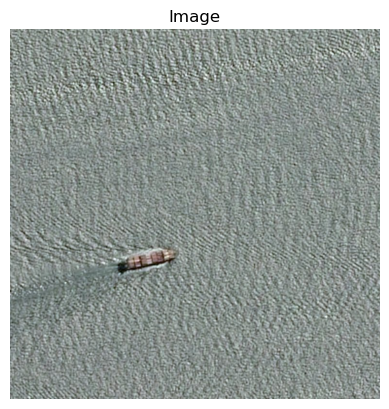

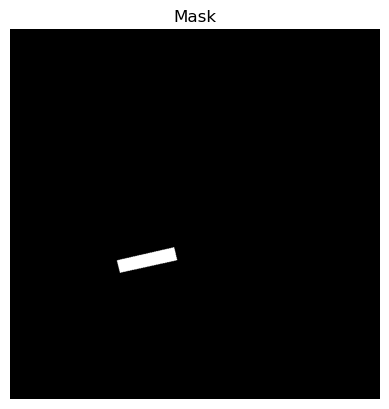

In [10]:
row = df.iloc[112]
image, mask = get_img_mask(df, row, train_images_dir, image_size)

# Display the image
plt.imshow(image.astype(np.uint8))
plt.axis('off')
plt.title('Image')
plt.show()

# Display the mask
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title('Mask')
plt.show()

In [11]:
crop_size = (192, 192)

def crop_image_and_mask(image, mask, crop_size):
    image = Image.fromarray(image.astype(np.uint8))
    mask = Image.fromarray(mask.astype(np.uint8))

    width, height = image.size
    crop_width, crop_height = crop_size

    cropped_images = []
    cropped_masks = []

    # Iterate over the image to create multiple crops
    for x in range(0, width, crop_width):
        for y in range(0, height, crop_height):
            # Calculate the crop coordinates
            left = x
            upper = y
            right = x + crop_width
            lower = y + crop_height

            # Crop the image
            cropped_image = image.crop((left, upper, right, lower))

            # Crop the mask with the same coordinates
            cropped_mask = mask.crop((left, upper, right, lower))

            # Append the cropped image and mask to the lists
            cropped_images.append(np.array(cropped_image))
            cropped_masks.append(np.array(cropped_mask))

    return cropped_images, cropped_masks


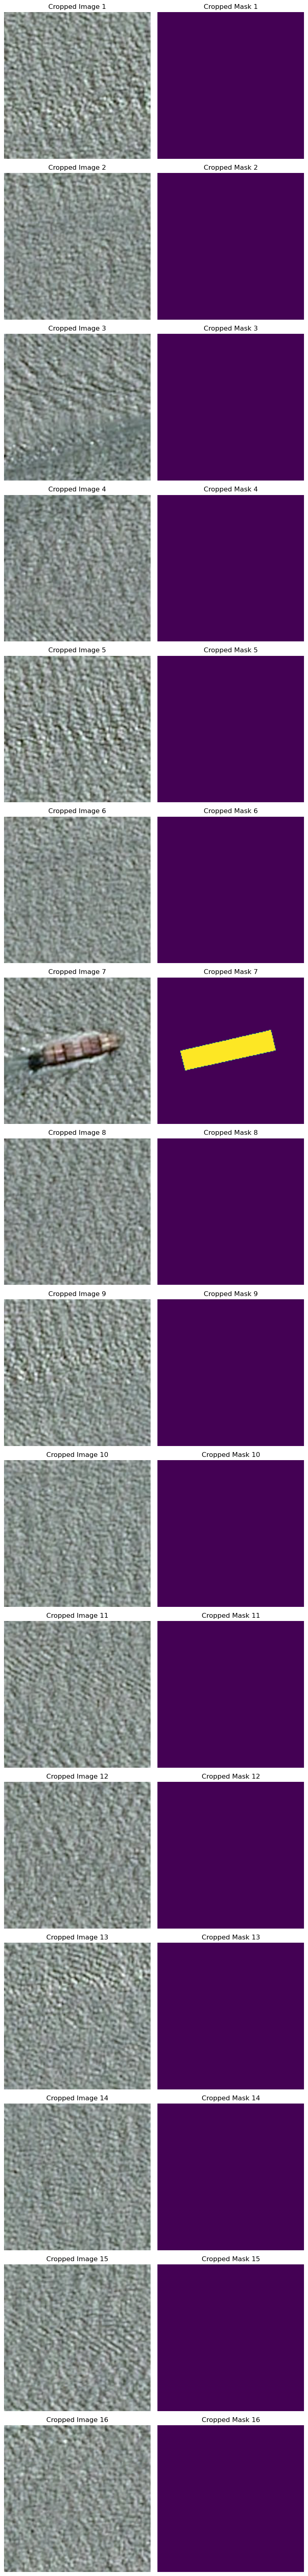

In [12]:
# Visualising crop

image, mask = get_img_mask(df.iloc[112], row, train_images_dir, image_size)

# Call the `crop_image_and_mask` function
cropped_images, cropped_masks = crop_image_and_mask(image, mask, crop_size)

# Visualize the cropped images and masks
num_crops = len(cropped_images)

fig, axs = plt.subplots(num_crops, 2, figsize=(8, num_crops*4))

for i in range(num_crops):
    axs[i, 0].imshow(cropped_images[i])
    axs[i, 0].set_title(f"Cropped Image {i+1}")
    axs[i, 0].axis('off')
    
    axs[i, 1].imshow(cropped_masks[i])
    axs[i, 1].set_title(f"Cropped Mask {i+1}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


In [13]:
def find_best(cropped_images, cropped_masks):
    max_area_index = max(range(len(cropped_masks)), key=lambda i: sum(sum(row) for row in cropped_masks[i]))
    return cropped_images[max_area_index], cropped_masks [max_area_index]

In [14]:
# Prepare data generator

class DataGenerator:
    def __init__(self, df, batch_size, image_size):
        self.df = df
        self.batch_size = batch_size
        self.image_size = image_size
        self.need_resize = need_resize
        self.datagen = ImageDataGenerator(rescale=1.0/255.0)

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def generate(self):
        while True:
            batch_indices = np.random.choice(len(self.df), size=self.batch_size, replace=False)
            batch_df = self.df.iloc[batch_indices]
            images = []
            masks = []
            for _, row in batch_df.iterrows():
                image, mask = get_img_mask(batch_df, row, train_images_dir, self.image_size)
                cropped_images, cropped_masks = crop_image_and_mask(image, mask, crop_size)
                best_image, best_mask = find_best(cropped_images, cropped_masks)
                images.append(best_image)
                masks.append(best_mask)

            images = np.array(images)
            masks = np.array(masks)

            # Apply data augmentation using ImageDataGenerator
            images = self.datagen.flow(images, shuffle=False).next()

            yield images, masks

In [15]:
def dice_score(pred_masks, true_masks, smooth=1e-7):
    intersection = K.sum(pred_masks * true_masks)
    union = K.sum(pred_masks) + K.sum(true_masks)

    dice = (2.0 * intersection + smooth) / (union + smooth)

    return dice


def bce_dice_loss(y_pred, y_target):
    # dice loss metric
    return binary_crossentropy(y_target, y_pred) + (1-dice_score(y_pred, y_target))

In [16]:
# Compile the model

model.compile(optimizer=Adam(1e-3, decay=1e-6), loss=bce_dice_loss, metrics=['binary_accuracy', dice_score])

In [17]:
# Create data generator

train_generator = DataGenerator(df_train_split, batch_size, image_size).generate()
val_generator = DataGenerator(df_val_split, batch_size, image_size).generate()

16


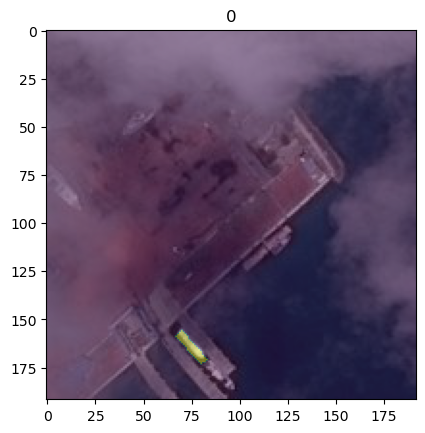

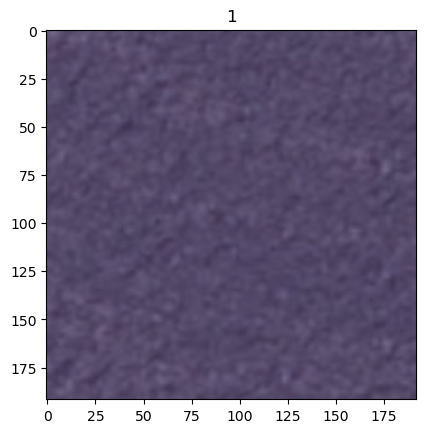

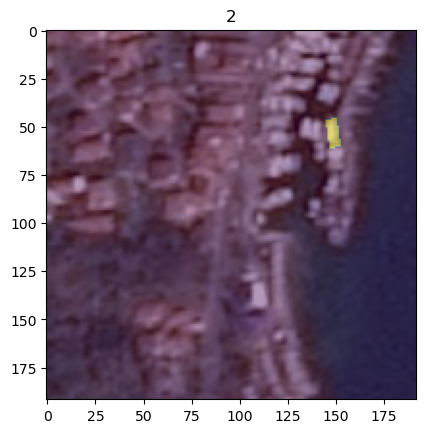

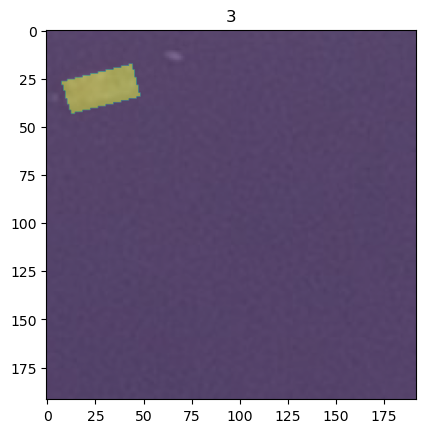

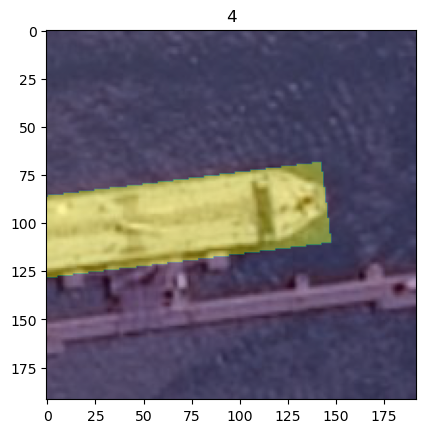

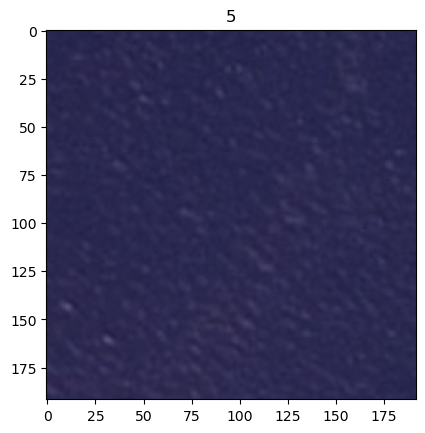

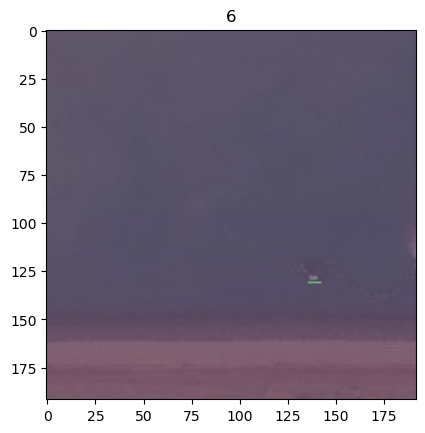

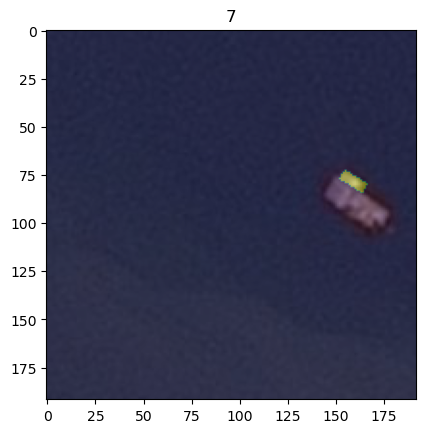

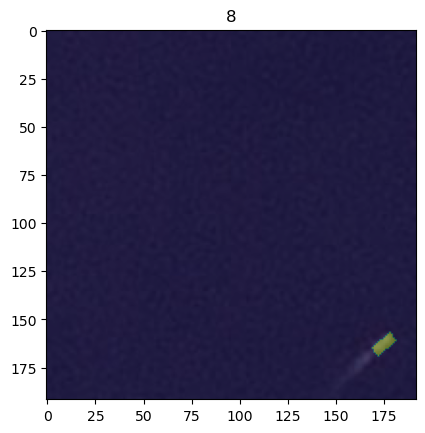

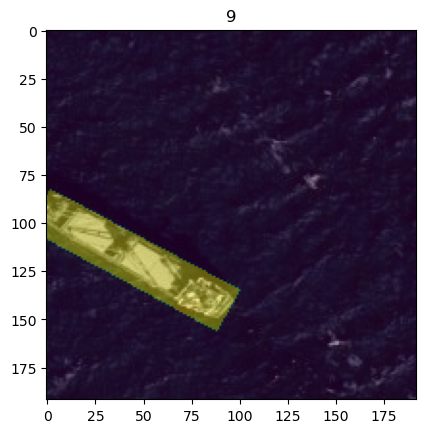

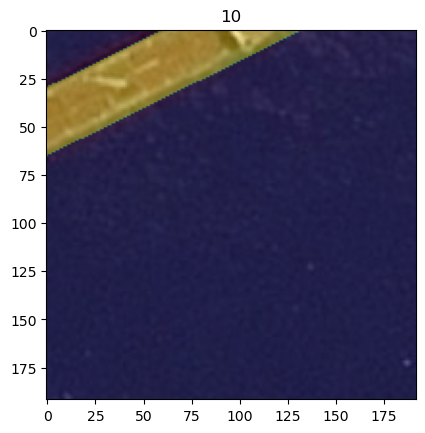

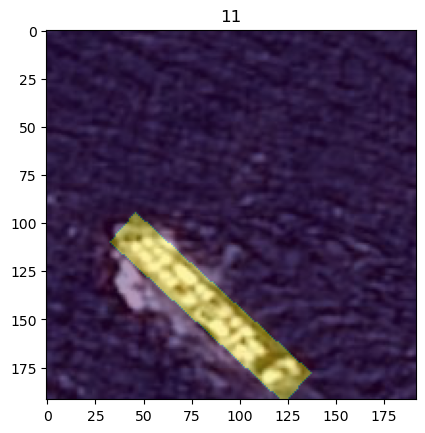

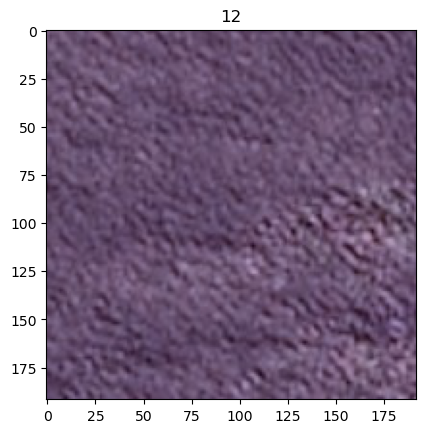

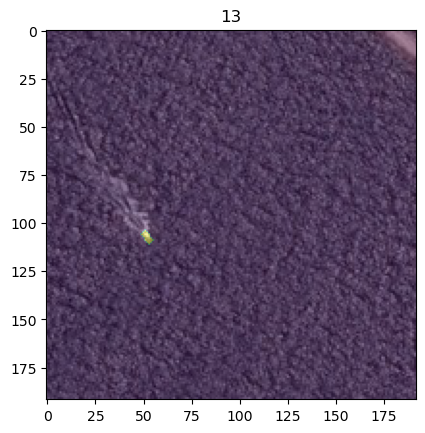

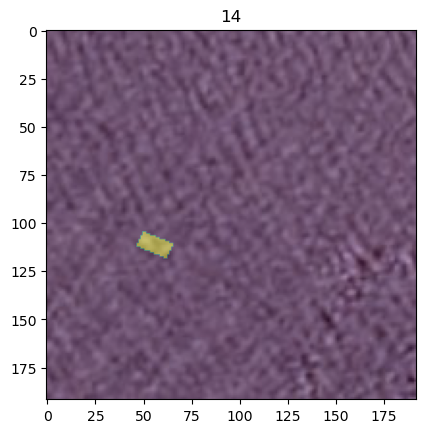

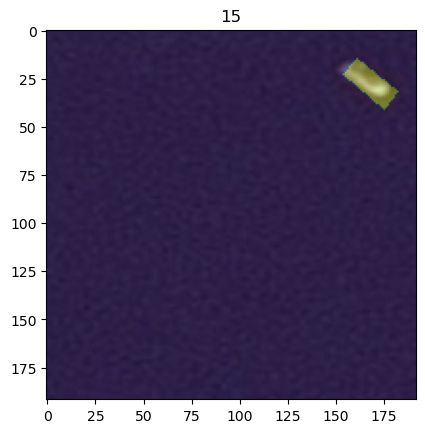

In [18]:
images, masks = next(train_generator)
print(len(images))
for i in range(0, (len(images))):
    plt.imshow(images[i])
    plt.imshow(masks[i], alpha=0.4)
    plt.title(i)

    plt.show()

In [19]:
#history = model.fit(train_generator,
                    epochs=epochs,
                    steps_per_epoch=len(df_train_split) // batch_size,
                    validation_data=val_generator,
                    validation_steps=len(df_val_split) // batch_size,
                    callbacks=callbacks_list,
                    verbose=1)
#model.save("./full_model")

IndentationError: unexpected indent (1280224095.py, line 2)